# 1. IMPORT DEPENDENCES

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import os
import cv2



In [2]:
tf.__version__

'2.9.1'

# 2. GET THE DATA READY FOR TRAINING

In [3]:
path = "../input/chest-ctscan-images/Data/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input/chest-ctscan-images/Data/train'

Then we set the path for this data.

In [4]:
train_path = "../input/chest-ctscan-images/Data/train"
valid_path = "../input/chest-ctscan-images/Data/valid"
test_path = "../input/chest-ctscan-images/Data/test"

In [6]:
image_paths = ['../input/chest-ctscan-images/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
'../input/chest-ctscan-images/Data/train/normal',
'../input/chest-ctscan-images/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
'../input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

def load_images(image_paths = image_paths, n=36):
    # Load the images from disk.
    images = []
    for i in range(len(image_paths)):
        images_ = [cv2.imread(image_paths[i]+'/'+path) for path in os.listdir(image_paths[i])[:int(n/4)]]
        images.append(images_)
    # Convert to a numpy array and return it.
    sample = np.asarray(images)
    return sample


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


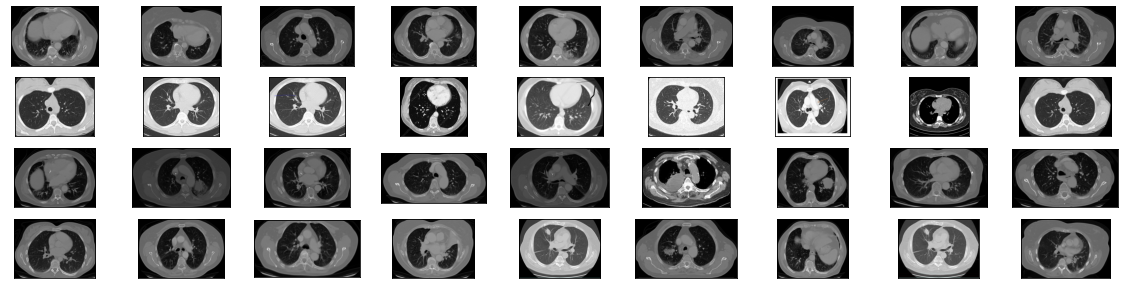

In [7]:
sample = load_images()
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

In [8]:
np.array(shapes).mean(axis=0)


array([305.19444444, 430.30555556,   3.        ])

# 3. IMAGE PREPROCESSING

* When using Gradient Descent, We should ensure that all Features have a similar scale, otherwise, it will take much longer to converge.

In [88]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# 4. BUILDING THE MODEL ARCHITECTURE

In [89]:
base_hidden_units = 8
weight_decay = 1e-3
model = Sequential([

    Conv2D(filters = 8 , kernel_size = 2, padding = 'same', activation = 'relu', input_shape = image_shape),
    MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, padding = 'same', activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),
    
    #Conv2D(filters = 64 , kernel_size = 2, padding = 'same', activation = 'relu',
     #     kernel_regularizer = regularizers.l2(weight_decay)),
    #MaxPooling2D(pool_size = 2),
    
    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(4,activation='softmax')
    
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 305, 430, 8)       104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 152, 215, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 152, 215, 16)      528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 76, 107, 16)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 76, 107, 16)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 130112)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)             

# 5. TRAIN THE MODEL

In [90]:
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 15)
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)

model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
20/20 [==============================] - 7s 298ms/step - loss: 1.3383 - acc: 0.3361 - val_loss: 1.3904 - val_acc: 0.3750

Epoch 00001: val_loss improved from inf to 1.39037, saving model to chestmodel.hdf5
Epoch 2/100
20/20 [==============================] - 7s 331ms/step - loss: 1.2601 - acc: 0.4339 - val_loss: 1.3175 - val_acc: 0.3889

Epoch 00002: val_loss improved from 1.39037 to 1.31745, saving model to chestmodel.hdf5
Epoch 3/100
20/20 [==============================] - 6s 290ms/step - loss: 1.2019 - acc: 0.4649 - val_loss: 1.2798 - val_acc: 0.4167

Epoch 00003: val_loss improved from 1.31745 to 1.27979, saving model to chestmodel.hdf5
Epoch 4/100
20/20 [==============================] - 6s 278ms/step - loss: 1.1624 - acc: 0.4927 - val_loss: 1.2523 - val_acc: 0.4444

Epoch 00004: val_loss improved from 1.27979 to 1.25225, saving model to chestmodel.hdf5
Epoch 5/100
20/20 [==============================] - 6s 292ms/step - loss: 1.0882 - acc: 0.5351 - val_loss: 1.2099 -

In [91]:
result = model.evaluate(test_generator)

10/10 [==============================] - 3s 277ms/step - loss: 1.4562 - acc: 0.5333


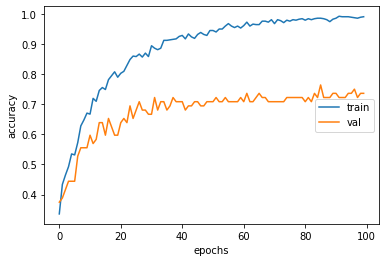

In [92]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# 6. TRANSFER LEARNING

## RESNET50

In [9]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [10]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

2022-06-26 12:54:34.625298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 12:54:34.729530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 12:54:34.730773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 12:54:34.733389: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


In [11]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,604,100
Trainable params: 14,988,292
Non-trainable params: 8,615,808
____________________________________

In [12]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [13]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [14]:
history_res = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

2022-06-26 12:54:41.145824: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-26 12:54:45.960438: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 [==============================] - 25s 704ms/step - loss: 2.4695 - acc: 0.2822 - val_loss: 1.4059 - val_acc: 0.3194

Epoch 00001: val_loss improved from inf to 1.40593, saving model to ./chest_CT_SCAN-ResNet50.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
20/20 [==============================] - 11s 532ms/step - loss: 2.2179 - acc: 0.3638 - val_loss: 1.2706 - val_acc: 0.4028

Epoch 00002: val_loss improved from 1.40593 to 1.27063, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 3/100
20/20 [==============================] - 10s 516ms/step - loss: 1.9242 - acc: 0.3866 - val_loss: 1.1674 - val_acc: 0.4444

Epoch 00003: val_loss improved from 1.27063 to 1.16742, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 4/100
20/20 [==============================] - 10s 513ms/step - loss: 1.5521 - acc: 0.4861 - val_loss: 1.0785 - val_acc: 0.5000

Epoch 00004: val_loss improved from 1.16742 to 1.07848, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 5/100
20/20 [==============================] - 10s 511ms/step - loss: 1.6118 - acc: 0.4649 - val_loss: 1.0152 - val_acc: 0.5278

Epoch 00005: val_loss improved from 1.07848 to 1.01523, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 6/100
20/20 [==============================] -

In [15]:
result = model.evaluate(test_generator)

10/10 [==============================] - 6s 606ms/step - loss: 0.3190 - acc: 0.8952


## VGG16

In [16]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [17]:
vgg_model = VGG16(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in vgg_model.layers:
    layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(vgg_model.layers):
#    print(i, layer.name, "-", layer.trainable)

58900480/58889256 [==============================] - 0s 0us/step


In [18]:
model = Sequential()
model.add(vgg_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 14,718,788
Trainable params: 3,076
Non-trainable params: 14,715,712
_________________________________________________________________


In [19]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [20]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-/vgg16.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [21]:
history_vgg = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
20/20 [==============================] - 23s 707ms/step - loss: 1.6895 - acc: 0.2202 - val_loss: 1.6254 - val_acc: 0.1806

Epoch 00001: val_loss improved from inf to 1.62540, saving model to ./chest_CT_SCAN-/vgg16.hdf5
Epoch 2/100
20/20 [==============================] - 9s 442ms/step - loss: 1.6683 - acc: 0.2349 - val_loss: 1.5899 - val_acc: 0.1806

Epoch 00002: val_loss improved from 1.62540 to 1.58988, saving model to ./chest_CT_SCAN-/vgg16.hdf5
Epoch 3/100
20/20 [==============================] - 9s 426ms/step - loss: 1.6548 - acc: 0.2480 - val_loss: 1.5595 - val_acc: 0.1806

Epoch 00003: val_loss improved from 1.58988 to 1.55946, saving model to ./chest_CT_SCAN-/vgg16.hdf5
Epoch 4/100
20/20 [==============================] - 9s 423ms/step - loss: 1.6489 - acc: 0.2333 - val_loss: 1.5338 - val_acc: 0.1806

Epoch 00004: val_loss improved from 1.55946 to 1.53383, saving model to ./chest_CT_SCAN-/vgg16.hdf5
Epoch 5/100
20/20 [==============================] - 8s 414ms/step 

In [22]:
result = model.evaluate(test_generator)

10/10 [==============================] - 11s 1s/step - loss: 1.0257 - acc: 0.5079


## RESNET101

In [23]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [24]:
res101_model = ResNet101(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res101_model.layers:
    layer.trainable = False

171458560/171446536 [==============================] - 3s 0us/step


In [25]:
model = Sequential()
model.add(res101_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(300))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 300)               614700    
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)               1200      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)              

In [26]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-/res101.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res101 = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
20/20 [==============================] - 17s 577ms/step - loss: 2.0680 - acc: 0.1811 - val_loss: 4.4404 - val_acc: 0.1806

Epoch 00001: val_loss improved from inf to 4.44044, saving model to ./chest_CT_SCAN-/res101.hdf5
Epoch 2/100
20/20 [==============================] - 10s 461ms/step - loss: 1.3436 - acc: 0.4095 - val_loss: 3.9423 - val_acc: 0.1806

Epoch 00002: val_loss improved from 4.44044 to 3.94230, saving model to ./chest_CT_SCAN-/res101.hdf5
Epoch 3/100
20/20 [==============================] - 10s 465ms/step - loss: 1.0839 - acc: 0.5188 - val_loss: 3.5667 - val_acc: 0.1806

Epoch 00003: val_loss improved from 3.94230 to 3.56669, saving model to ./chest_CT_SCAN-/res101.hdf5
Epoch 4/100
20/20 [==============================] - 10s 477ms/step - loss: 0.9862 - acc: 0.5726 - val_loss: 3.1813 - val_acc: 0.1806

Epoch 00004: val_loss improved from 3.56669 to 3.18134, saving model to ./chest_CT_SCAN-/res101.hdf5
Epoch 5/100
20/20 [==============================] - 10s 467

In [27]:
result = model.evaluate(test_generator)

10/10 [==============================] - 5s 419ms/step - loss: 1.1575 - acc: 0.5968


## VGG19

In [28]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=vgg19.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=vgg19.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=vgg19.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [29]:
vgg19_model = VGG19(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in vgg19_model.layers:
    layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

80150528/80134624 [==============================] - 0s 0us/step


In [30]:
model = Sequential()
model.add(vgg19_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 20,028,484
Trainable params: 3,076
Non-trainable params: 20,025,408
_________________________________________________________________


In [31]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [32]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-VGG19.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [33]:
history_vgg19 = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - 11s 544ms/step - loss: 1.9839 - acc: 0.2529 - val_loss: 2.4675 - val_acc: 0.1944

Epoch 00001: val_loss improved from inf to 2.46753, saving model to ./chest_CT_SCAN-VGG19.hdf5
Epoch 2/200
20/20 [==============================] - 10s 495ms/step - loss: 1.9583 - acc: 0.2741 - val_loss: 2.2670 - val_acc: 0.1806

Epoch 00002: val_loss improved from 2.46753 to 2.26699, saving model to ./chest_CT_SCAN-VGG19.hdf5
Epoch 3/200
20/20 [==============================] - 10s 501ms/step - loss: 1.9392 - acc: 0.2643 - val_loss: 2.1317 - val_acc: 0.1944

Epoch 00003: val_loss improved from 2.26699 to 2.13167, saving model to ./chest_CT_SCAN-VGG19.hdf5
Epoch 4/200
20/20 [==============================] - 10s 501ms/step - loss: 1.9239 - acc: 0.2692 - val_loss: 2.0467 - val_acc: 0.2222

Epoch 00004: val_loss improved from 2.13167 to 2.04674, saving model to ./chest_CT_SCAN-VGG19.hdf5
Epoch 5/200
20/20 [==============================] - 10s 496ms/step 

In [34]:
result = model.evaluate(test_generator)

10/10 [==============================] - 5s 457ms/step - loss: 1.1353 - acc: 0.5651


## DenseNet201

In [35]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [36]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(dense_model.layers):
#    print(i, layer.name, "-", layer.trainable)


74850304/74836368 [==============================] - 1s 0us/step


In [37]:
model = Sequential()
model.add(dense_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
flatten_4 (Flatten)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 7684      
Total params: 18,337,348
Trainable params: 6,990,084
Non-trainable params: 11,347,264
_________________________________________________________________


In [38]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [39]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [40]:
history_dense = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - 28s 773ms/step - loss: 1.3360 - acc: 0.4290 - val_loss: 1.3543 - val_acc: 0.3194

Epoch 00001: val_loss improved from inf to 1.35428, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 2/200
20/20 [==============================] - 11s 525ms/step - loss: 0.7707 - acc: 0.7374 - val_loss: 1.2322 - val_acc: 0.4167

Epoch 00002: val_loss improved from 1.35428 to 1.23215, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 3/200
20/20 [==============================] - 11s 515ms/step - loss: 0.5573 - acc: 0.8450 - val_loss: 1.1418 - val_acc: 0.5139

Epoch 00003: val_loss improved from 1.23215 to 1.14177, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 4/200
20/20 [==============================] - 11s 543ms/step - loss: 0.4206 - acc: 0.9021 - val_loss: 1.0443 - val_acc: 0.5417

Epoch 00004: val_loss improved from 1.14177 to 1.04427, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 5/200
20/20 [=========================

In [41]:
result = model.evaluate(test_generator)

10/10 [==============================] - 7s 645ms/step - loss: 0.5469 - acc: 0.8190


## EfficientNetB4

In [42]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [43]:
efficient_model = EfficientNetB4(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in efficient_model.layers:
    if 'block7'not in layer.name and'top' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(efficient_model.layers):
#    print(i, layer.name, "-", layer.trainable)


71696384/71686520 [==============================] - 1s 0us/step


In [44]:
model = Sequential()
model.add(efficient_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
flatten_5 (Flatten)          (None, 1792)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1792)              7168      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 7172      
Total params: 17,688,163
Trainable params: 5,287,160
Non-trainable params: 12,401,003
_________________________________________________________________


In [45]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [46]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-EfficientNet.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [47]:
history_efficient = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - 24s 657ms/step - loss: 1.8937 - acc: 0.2643 - val_loss: 1.4137 - val_acc: 0.3194

Epoch 00001: val_loss improved from inf to 1.41367, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 2/200
20/20 [==============================] - 10s 466ms/step - loss: 1.4198 - acc: 0.3866 - val_loss: 1.3631 - val_acc: 0.3611

Epoch 00002: val_loss improved from 1.41367 to 1.36310, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 3/200
20/20 [==============================] - 10s 491ms/step - loss: 1.0620 - acc: 0.5677 - val_loss: 1.3133 - val_acc: 0.3889

Epoch 00003: val_loss improved from 1.36310 to 1.31327, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 4/200
20/20 [==============================] - 10s 464ms/step - loss: 0.9396 - acc: 0.6232 - val_loss: 1.2599 - val_acc: 0.4167

Epoch 00004: val_loss improved from 1.31327 to 1.25986, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 5/200
20/20 [=====================

In [48]:
result = model.evaluate(test_generator)

10/10 [==============================] - 5s 457ms/step - loss: 0.4574 - acc: 0.8540


## MobileNetV2

In [49]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=mobilenet_v2.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=mobilenet_v2.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=mobilenet_v2.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [50]:
mobile_model = MobileNetV2(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in mobile_model.layers:
    if 'block_15'not in layer.name and'block_16' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(mobile_model.layers):
#    print(i, layer.name, "-", layer.trainable)

9420800/9406464 [==============================] - 0s 0us/step


In [51]:
model = Sequential()
model.add(mobile_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 5124      
Total params: 2,268,228
Trainable params: 801,604
Non-trainable params: 1,466,624
______________________________________

In [52]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [53]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-MobileNet.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [54]:
history_mobile = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - 13s 460ms/step - loss: 2.6179 - acc: 0.2447 - val_loss: 1.3702 - val_acc: 0.3333

Epoch 00001: val_loss improved from inf to 1.37016, saving model to ./chest_CT_SCAN-MobileNet.hdf5
Epoch 2/200
20/20 [==============================] - 8s 391ms/step - loss: 2.3434 - acc: 0.2855 - val_loss: 1.3503 - val_acc: 0.3333

Epoch 00002: val_loss improved from 1.37016 to 1.35033, saving model to ./chest_CT_SCAN-MobileNet.hdf5
Epoch 3/200
20/20 [==============================] - 8s 388ms/step - loss: 2.2709 - acc: 0.3002 - val_loss: 1.3240 - val_acc: 0.3333

Epoch 00003: val_loss improved from 1.35033 to 1.32396, saving model to ./chest_CT_SCAN-MobileNet.hdf5
Epoch 4/200
20/20 [==============================] - 8s 387ms/step - loss: 2.3761 - acc: 0.3148 - val_loss: 1.3032 - val_acc: 0.3056

Epoch 00004: val_loss improved from 1.32396 to 1.30318, saving model to ./chest_CT_SCAN-MobileNet.hdf5
Epoch 5/200
20/20 [==============================] - 8s

In [55]:
result = model.evaluate(test_generator)

10/10 [==============================] - 4s 383ms/step - loss: 0.6585 - acc: 0.7333


---

# The Most three promised models are:
* ResNet50 **86 on test data**
* DenseNet201 **88 on test data**
* EfficientNetB4 **90 on test data**

# Let's Play with HyperParameter Tuning

## ResNet50

In [5]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32')#, preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')#, preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32')#, preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [6]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

2022-06-27 14:39:12.274930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 14:39:12.368983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 14:39:12.369726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 14:39:12.371282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [7]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,604,100
Trainable params: 14,988,292
Non-trainable params: 8,615,808
____________________________________

In [8]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [9]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [10]:
history_res = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

2022-06-27 14:39:25.193566: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-06-27 14:39:30.532919: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 [==============================] - 24s 639ms/step - loss: 2.0633 - acc: 0.3197 - val_loss: 1.3436 - val_acc: 0.4028

Epoch 00001: val_loss improved from inf to 1.34360, saving model to ./chest_CT_SCAN-ResNet50.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
20/20 [==============================] - 9s 424ms/step - loss: 1.3716 - acc: 0.4829 - val_loss: 1.1270 - val_acc: 0.4444

Epoch 00002: val_loss improved from 1.34360 to 1.12697, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 3/200
20/20 [==============================] - 9s 458ms/step - loss: 1.1629 - acc: 0.5612 - val_loss: 1.0275 - val_acc: 0.4583

Epoch 00003: val_loss improved from 1.12697 to 1.02752, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 4/200
20/20 [==============================] - 9s 419ms/step - loss: 1.0435 - acc: 0.6069 - val_loss: 0.9677 - val_acc: 0.4861

Epoch 00004: val_loss improved from 1.02752 to 0.96773, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 5/200
20/20 [==============================] - 9s 420ms/step - loss: 0.8340 - acc: 0.6770 - val_loss: 0.9091 - val_acc: 0.5833

Epoch 00005: val_loss improved from 0.96773 to 0.90907, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 6/200
20/20 [==============================] - 9s 

In [11]:
result = model.evaluate(test_generator)

10/10 [==============================] - 6s 584ms/step - loss: 0.2946 - acc: 0.9175


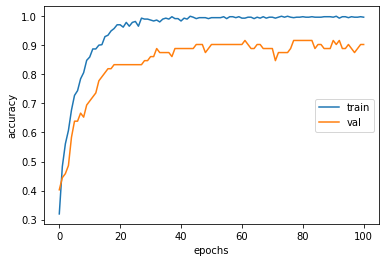

In [12]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DenseNet201

In [64]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [65]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(dense_model.layers):
#    print(i, layer.name, "-", layer.trainable)


In [66]:
model = Sequential()
model.add(dense_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
flatten_8 (Flatten)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1920)              7680      
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 7684      
Total params: 18,337,348
Trainable params: 6,990,084
Non-trainable params: 11,347,264
_________________________________________________________________


In [67]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [68]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [69]:
history_dense = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - 11s 522ms/step - loss: 0.1188 - acc: 0.9984 - val_loss: 0.6524 - val_acc: 0.7639

Epoch 00009: val_loss improved from 0.70285 to 0.65240, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 10/200
20/20 [==============================] - 11s 537ms/step - loss: 0.1027 - acc: 0.9984 - val_loss: 0.6091 - val_acc: 0.7778

Epoch 00010: val_loss improved from 0.65240 to 0.60909, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 11/200
20/20 [==============================] - 10s 515ms/step - loss: 0.1005 - acc: 0.9951 - val_loss: 0.5631 - val_acc: 0.8194

Epoch 00011: val_loss improved from 0.60909 to 0.56315, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 12/200
20/20 [==============================] - 11s 532ms/step - loss: 0.0938 - acc: 0.9967 - val_loss: 0.5236 - val_acc: 0.8611

Epoch 00012: val_loss improved from 0.56315 to 0.52361, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 13/200
20/20 [=================

In [70]:
result = model.evaluate(test_generator)

10/10 [==============================] - 5s 433ms/step - loss: 0.3347 - acc: 0.9016


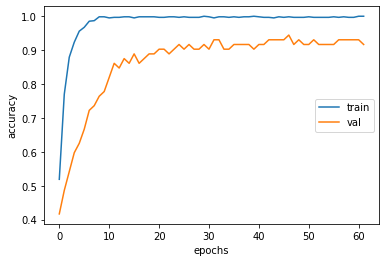

In [74]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## EffiecientNetB4

In [75]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [76]:
efficient_model = EfficientNetB4(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in efficient_model.layers:
    if 'block7'not in layer.name and'top' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(efficient_model.layers):
#    print(i, layer.name, "-", layer.trainable)


In [77]:
model = Sequential()
model.add(efficient_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
flatten_9 (Flatten)          (None, 1792)              0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1792)              7168      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 7172      
Total params: 17,688,163
Trainable params: 5,287,160
Non-trainable params: 12,401,003
_________________________________________________________________


In [78]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [79]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-EfficientNet.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [80]:
history_efficient = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - 22s 630ms/step - loss: 1.9451 - acc: 0.2626 - val_loss: 1.3411 - val_acc: 0.2917

Epoch 00001: val_loss improved from inf to 1.34111, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 2/200
20/20 [==============================] - 10s 478ms/step - loss: 1.4326 - acc: 0.4290 - val_loss: 1.2882 - val_acc: 0.2917

Epoch 00002: val_loss improved from 1.34111 to 1.28825, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 3/200
20/20 [==============================] - 10s 473ms/step - loss: 1.1636 - acc: 0.5334 - val_loss: 1.2401 - val_acc: 0.4028

Epoch 00003: val_loss improved from 1.28825 to 1.24007, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 4/200
20/20 [==============================] - 9s 482ms/step - loss: 1.0065 - acc: 0.6085 - val_loss: 1.1879 - val_acc: 0.4722

Epoch 00004: val_loss improved from 1.24007 to 1.18793, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 5/200
20/20 [======================

In [81]:
result = model.evaluate(test_generator)

10/10 [==============================] - 4s 403ms/step - loss: 0.3353 - acc: 0.8952


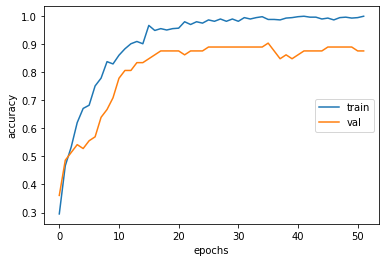

In [82]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Final Models are:
* **ResNet50** with **train 99.5  validation 89  test 91.7**
* **DenseNet201** with **train 100 validation 94.5 test 90**
* **EfficientNetB4** with **train 99 validation 94.5 test 89.5**

In [3]:
ResNet_Path = '../input/models/chest_CT_SCAN-ResNet50(1).hdf5'
DenseNet_Path = '../input/models/chest_CT_SCAN-DenseNet201.hdf5'

ResNet_model = tf.keras.models.load_model(ResNet_Path)
DenseNet_model = tf.keras.models.load_model(DenseNet_Path)

In [4]:
path_adeno = '../input/chest-ctscan-images/Data/test/adenocarcinoma'
path_large = '../input/chest-ctscan-images/Data/test/large.cell.carcinoma'
path_normal = '../input/chest-ctscan-images/Data/test/normal'
path_squamous = '../input/chest-ctscan-images/Data/test/squamous.cell.carcinoma'

results_total = {'adeno':{},'large':{},'normal':{},'squamous':{}}
results_resnet = {'adeno':{},'large':{},'normal':{},'squamous':{}}
results_densenet = {'adeno':{},'large':{},'normal':{},'squamous':{}}

keys = ['adeno','large','normal','squamous']
for path ,key in zip([path_adeno,path_large,path_normal,path_squamous],keys):
    images = os.listdir(path)
    
    for image in images:

        my_image = load_img(path+'/'+image, target_size=(460, 460))
        my_image = img_to_array(my_image)
        my_image = my_image.reshape((1, 460, 460,3))
        my_image_dense = my_image.copy()
    # ResNet Only
        results_resnet[key][np.argmax(ResNet_model.predict(my_image))] = results_resnet.get(key).get(np.argmax(ResNet_model.predict(my_image)),0) +1
    # ResNet + DenseNet
        if np.max(ResNet_model.predict(my_image)) >=  np.max(DenseNet_model.predict(my_image)):
            
            results_total[key][np.argmax(ResNet_model.predict(my_image))] = results_total.get(key).get(np.argmax(ResNet_model.predict(my_image)),0) +1
        else:
            my_image = densenet.preprocess_input(my_image)
            results_total[key][np.argmax(DenseNet_model.predict(my_image))] = results_total[key].get(np.argmax(DenseNet_model.predict(my_image)),0) +1
    # DenseNet Only
        my_image_dense = densenet.preprocess_input(my_image_dense)
        results_densenet[key][np.argmax(DenseNet_model.predict(my_image_dense))] = results_densenet.get(key).get(np.argmax(DenseNet_model.predict(my_image_dense)),0) +1


2022-06-28 18:16:45.841578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-28 18:16:48.143904: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [5]:
print(results_total,'\n',results_resnet,'\n',results_densenet)

{'adeno': {0: 109, 3: 2, 1: 9}, 'large': {1: 48, 0: 2, 3: 1}, 'normal': {2: 53, 1: 1}, 'squamous': {3: 83, 0: 7}} 
 {'adeno': {0: 107, 3: 2, 1: 11}, 'large': {1: 49, 0: 2}, 'normal': {2: 53, 1: 1}, 'squamous': {3: 78, 1: 3, 0: 9}} 
 {'adeno': {0: 103, 3: 6, 1: 11}, 'large': {1: 45, 3: 2, 0: 4}, 'normal': {2: 53, 1: 1}, 'squamous': {3: 76, 0: 13, 1: 1}}


# From results we can see that using both models **argmax(ResNet + DenseNet)** is more accurate rather than using only one of them

In [25]:
adeno_acc = 91 # conflicting with large
large_acc = 94 
normal_acc = 98.5
squamous_acc = 92 #conflicting with adeno

acc = {'adeno_acc':91,'large_acc':94,'normal_acc':98.5,'squamous_acc':92}
df_acc = pd.DataFrame(acc.values(),index=acc.keys(),columns=['ACCURACY %'])
df_acc

,ACCURACY %
adeno_acc,91.0
large_acc,94.0
normal_acc,98.5
squamous_acc,92.0


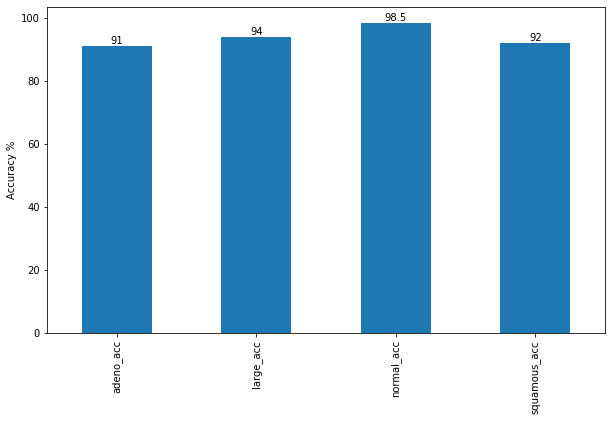

In [47]:
ax = df_acc.plot(kind='bar', stacked= True, figsize= (10,6), ylabel= 'Accuracy %',legend = None)

for container in ax.containers:
    ax.bar_label(container)